In [684]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [685]:
caffe.set_mode_cpu()

model_def = '/home/qin/task_20160712/models/xim_dep.prototxt'
model_weights = '/home/qin/task_20160712/models/caffe_alexnet_train_iter_25000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [686]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load('/home/qin/task_20160712/data/mean.ipy.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 113.68993834522045), ('G', 114.84227739413581), ('R', 112.68510068575543)]


(720, 1280, 3)


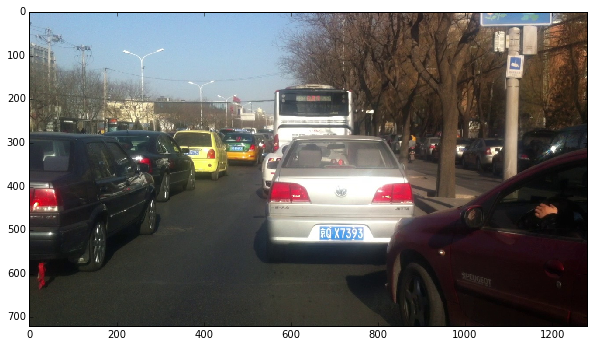

In [687]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                            720, 1280)  # image size is 227x227

image = caffe.io.load_image('/home/qin/1.jpg')
print image.shape
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [688]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.blobs['data'].data[...] = transformed_image
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 28 ms per loop


In [689]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 720, 1280)
conv1	(1, 16, 720, 1280)
conv2	(1, 32, 720, 1280)
pool2	(1, 32, 360, 640)
conv3	(1, 64, 360, 640)
pool3	(1, 64, 180, 320)
conv4	(1, 32, 180, 320)
conv5	(1, 16, 180, 320)
conv6	(1, 16, 180, 320)
conv7	(1, 5, 180, 320)


In [690]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(16, 3, 3, 3) (16,)
conv2	(32, 16, 3, 3) (32,)
conv3	(64, 32, 3, 3) (64,)
conv4	(32, 64, 3, 3) (32,)
conv5	(16, 32, 3, 3) (16,)
conv6	(16, 16, 11, 11) (16,)
conv7	(5, 16, 5, 5) (5,)


In [691]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

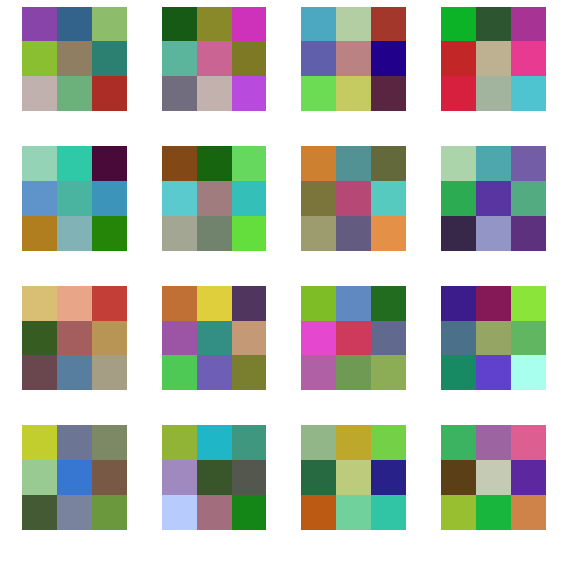

In [692]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

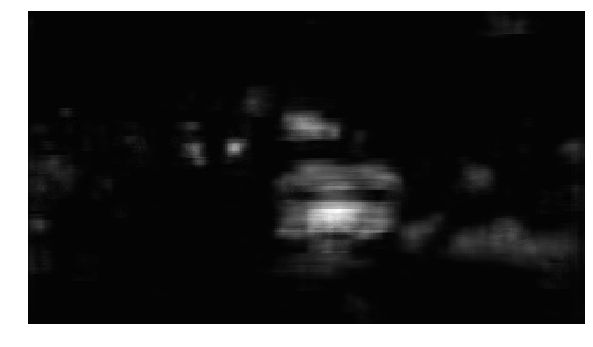

In [693]:
feat = net.blobs['conv7'].data[0, 0:1]
#feat[feat < 0.5] =0
vis_square(feat)


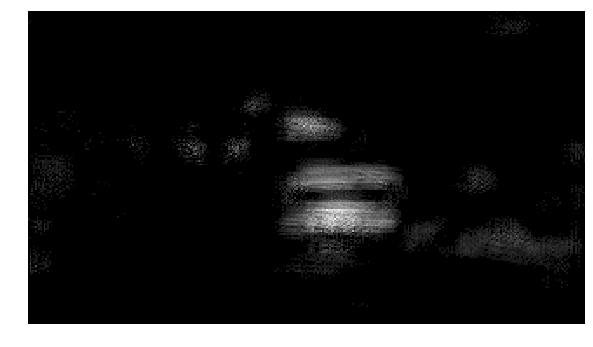

In [696]:
feat = net.blobs['conv7'].data[0, 1:2]
feat[feat < 0.01] =0
vis_square(feat)



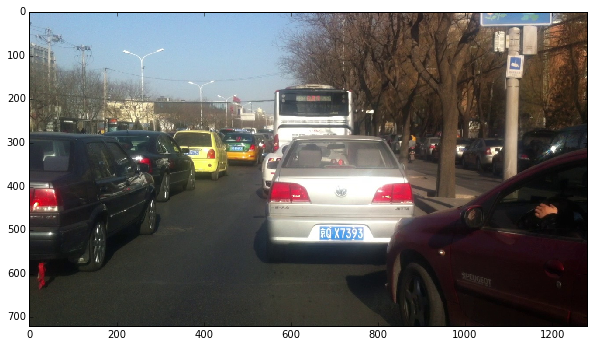

In [695]:
plt.imshow(image)